In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/예선데이터/"

/content/drive/MyDrive/Colab Notebooks/예선데이터


In [3]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 707 kB 25.8 MB/s 
     |████████████████████████████████| 419 kB 54.4 MB/s 
     |████████████████████████████████| 5.9 MB 59.4 MB/s 
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [4]:
!nvidia-smi

Thu Sep 15 00:42:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!pip freeze >requirements.txt

In [6]:
import os
import pickle
import datetime
import json
from typing import List

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR, OneCycleLR

import matplotlib.pyplot as plt
import pytorch_lightning as pl

# Dataset

In [7]:
pl.seed_everything(2023)

INFO:pytorch_lightning.utilities.seed:Global seed set to 2023


2023

In [8]:
train_input_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/예선데이터/train_processed_input_2022-09-11 11:05:21.378887.csv")
train_output_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/예선데이터/train_processed_output.csv")
test_input_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/예선데이터/test_processed_input_2022-09-11 11:05:21.378887.csv")
answer_sample = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/예선데이터/answer_sample.csv")

In [9]:
train_input_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10626 entries, 0 to 10625
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Sample_no               10626 non-null  int64  
 1   Week                    10626 non-null  float64
 2   InCO2                   10626 non-null  float64
 3   InHumidity              10626 non-null  float64
 4   InTemp                  10626 non-null  float64
 5   SolarRadiation          10626 non-null  float64
 6   NutrientSupplyEC(ds/m)  10626 non-null  float64
 7   NutrientSupplypH        10626 non-null  float64
 8   Doy                     10626 non-null  float64
 9   TotalNutrientSupply     10626 non-null  float64
 10  CultivationForm_soil    10626 non-null  int64  
 11  CultivationForm_water   10626 non-null  int64  
dtypes: float64(9), int64(3)
memory usage: 996.3 KB


In [10]:
class CultureDataset(Dataset):
    def __init__(self, input_df:pd.DataFrame, output_df:pd.DataFrame = None, train_mode = True):
        self.input_df = input_df
        self.output_df = output_df
        self.train_mode = train_mode

        self.input_data = []
        self.label_data = []
        
        for key, value in self.input_df.groupby("Sample_no", as_index = False).groups.items():
            x = self.input_df.loc[value].drop("Sample_no", axis = 1).to_numpy()
            self.input_data.append(torch.tensor(x, dtype=torch.float32))
            
            if self.train_mode:
                y = np.squeeze(self.output_df[self.output_df["Sample_no"] == key].drop(["Sample_no", "Date", "Week"], axis = 1).to_numpy())
            else:
                y = np.zeros(3)

            self.label_data.append(torch.tensor(y, dtype=torch.float32))


    def __getitem__(self, idx):
        x = self.input_data[idx]
        y = self.label_data[idx]

        return x, y

    def __len__(self):
        return len(self.input_data)

In [70]:
batch_size = 16
epochs = 300 # 500해봅시다
input_size = train_input_df.shape[1] - 1
train_test_split_ratio = 0.95 # best 1.0
ensemble_size = 5

In [71]:
culturedataset = CultureDataset(train_input_df, train_output_df)
test_dataset = CultureDataset(test_input_df, train_mode = False)

In [72]:
dataset_length = len(culturedataset)

train_len = int(dataset_length * train_test_split_ratio)
val_len = dataset_length - train_len

train_dataset, val_dataset = random_split(culturedataset, [train_len, val_len])

In [73]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [102]:
total_dataloader = DataLoader(culturedataset, batch_size = batch_size, shuffle = True)

In [75]:
def predict(model:nn.Module, trainer:pl.Trainer, df:pd.DataFrame, dataloader)->pd.DataFrame:
    print(f"Best epoch : {model.best_epoch}, Best score : {model.best_score}")
    model.load_state_dict(model.best_model)

    predictions = trainer.predict(model, dataloaders = dataloader)

    results = np.concatenate([pred.detach().numpy() for pred in predictions])
    df[["생장길이", "줄기직경", "개화군"]] = results

    return df

# Model 정의

In [76]:
class BaseSequenceModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader, model_id = None):
        super().__init__()
        self.loss = self.custom_loss
        self.train_record = []
        self.val_record = []
        self.lr_record = []
        self.train_loss = 0
        self.val_loss = 0
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.best_model = None
        self.best_epoch = None
        self.best_score = None
        self.optimizer = None
        self.lr_scheduler = None
        self.name = self.__class__.__name__ + str(model_id) if model_id else self.__class__.__name__
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader

    def forward(self, x):
        raise NotImplementedError

    def configure_optimizers(self):
        raise NotImplementedError

    def custom_loss(self, out, tgt):
        growth_mae = self.mae(out[:, 0], tgt[:,0])
        stem_mae = self.mae(out[:, 1], tgt[:, 1])
        flowering_mae = self.mae(out[:, 2], tgt[:, 2])

        return (growth_mae*0.1 + stem_mae + flowering_mae)/3

    def mae(self, true, pred):
        return torch.mean(torch.abs(true - pred))

    def training_step(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.train_loss += loss
        
        return loss

    def on_train_epoch_end(self) -> None:
        self.train_record.append(self.train_loss.cpu().detach().numpy() / len(self.train_dataloader))
        self.train_loss = 0

        self.val_record.append(self.val_loss.cpu().detach().numpy() / len(self.val_dataloader))
        self.val_loss = 0
        self.lr_record.append(self.lr_scheduler.get_last_lr())  

        # early-stopping
        if min(self.val_record) == self.val_record[-1]:
            self.best_model = self.state_dict()
            self.best_epoch = len(self.val_record) - 1
            self.best_score = self.val_record[-1]

        self.log("loss", {f"{self.name}_train_loss" : self.train_record[-1], f"{self.name}_val_loss" : self.val_record[-1]})
        return

    def validation_step(self, batch, batch_idx):
        x, y = batch
        
        y_hat = self(x)
        loss = self.loss(y_hat, y)

        self.val_loss += loss

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self(x)
        return y_hat

In [92]:
class ConvLSTMSequenceModel(BaseSequenceModel):
    def __init__(self, input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader, model_id = None):
        super().__init__(input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader, model_id)

        self.conv1 = nn.Sequential(
            nn.Conv1d(self.input_size, 64, 3, stride = 1, padding = 1),
            nn.BatchNorm1d(64),
            nn.ReLU()
        )

        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, 3, stride = 1, padding = 1),
            nn.BatchNorm1d(128),
            nn.ReLU()
        )

        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, 3, stride = 1, padding = 1),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )

        self.lstm = nn.Sequential(
            nn.LSTM(input_size = 256, hidden_size = self.hidden_size, num_layers = self.num_layers, batch_first = True)
        )

        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(self.dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(self.dropout), 
            nn.Linear(128, 3)           
        )

    def forward(self, x):
        # convolution layer 1
        x = x.reshape(-1, self.input_size, 7)
        x = self.conv1(x)

        # convolution layer 2
        x = self.conv2(x)

        # convolution layer 3
        x = self.conv3(x)

        # lstm layer
        x = x.reshape(-1, 7, 256)
        x, _ = self.lstm(x)

        # fully connected layer
        x = x[:, -1, :].reshape(-1, self.hidden_size)
        x = self.fc(x)

        return x
    
    def configure_optimizers(self):
        self.optimizer = Adam(self.parameters(), lr = self.learning_rate)
        self.lr_scheduler = OneCycleLR(self.optimizer, max_lr = learning_rate, total_steps = epochs, pct_start = 0.3, final_div_factor = 1000)

        return [self.optimizer], [self.lr_scheduler]

# Train

In [93]:
learning_rate = 1e-4
hidden_size = 512
num_layers = 2
dropout = 0.25 # 0.2

In [94]:
logger = pl.loggers.TensorBoardLogger("ConvLSTM")

In [95]:
convlstm_model = ConvLSTMSequenceModel(input_size, hidden_size, num_layers, learning_rate, dropout, train_dataloader, val_dataloader)

# convlstm_trainer = pl.Trainer(max_epochs = epochs, logger = logger)
convlstm_trainer = pl.Trainer(max_epochs = epochs, accelerator='gpu', devices=1, logger = logger)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [96]:
convlstm_model_architecture = convlstm_model.__repr__()
print(convlstm_model_architecture)

ConvLSTMSequenceModel(
  (conv1): Sequential(
    (0): Conv1d(11, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (lstm): Sequential(
    (0): LSTM(256, 512, num_layers=2, batch_first=True)
  )
  (fc): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inplace=False)
    (6): Linear(in_features=256

In [97]:
convlstm_trainer.fit(convlstm_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 2.3 K 
1 | conv2 | Sequential | 25.0 K
2 | conv3 | Sequential | 99.1 K
3 | lstm  | Sequential | 3.7 M 
4 | fc    | Sequential | 427 K 
-------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.927    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:289: UserWarning: The ``compute`` method of metric _ResultMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  f"The ``compute`` method of metric {self.__class__.__name__}"


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


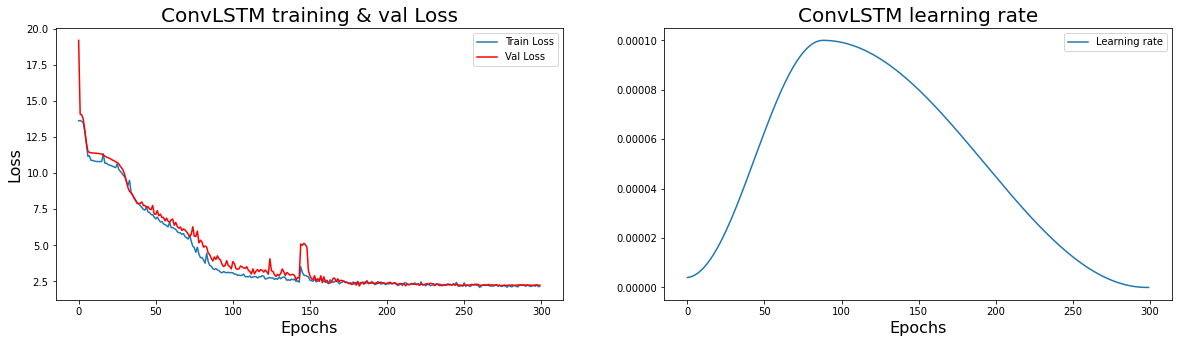

In [98]:
plt.figure(figsize= (20, 5))

plt.subplot(1, 2, 1)
plt.plot(convlstm_model.train_record, label="Train Loss") 
plt.plot(convlstm_model.val_record, 'r', label="Val Loss") 
plt.title('ConvLSTM training & val Loss', fontsize=20) 
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(convlstm_model.lr_record, label="Learning rate")  
plt.title('ConvLSTM learning rate', fontsize=20) 
plt.xlabel('Epochs',fontsize=16)
plt.legend()
plt.show()

In [99]:
convlstm_test_result = predict(convlstm_model, convlstm_trainer, answer_sample, test_dataloader)

Best epoch : 249, Best score : 2.169706344604492


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

In [103]:
total_convlstm_model = ConvLSTMSequenceModel(input_size, hidden_size, num_layers, learning_rate, dropout, total_dataloader, val_dataloader)

# convlstm_trainer = pl.Trainer(max_epochs = epochs, logger = logger)
total_convlstm_trainer = pl.Trainer(max_epochs = epochs, accelerator='gpu', devices=1, logger = logger)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [104]:
total_convlstm_trainer.fit(total_convlstm_model, train_dataloaders=total_dataloader, val_dataloaders=val_dataloader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type       | Params
-------------------------------------
0 | conv1 | Sequential | 2.3 K 
1 | conv2 | Sequential | 25.0 K
2 | conv3 | Sequential | 99.1 K
3 | lstm  | Sequential | 3.7 M 
4 | fc    | Sequential | 427 K 
-------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.927    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=300` reached.


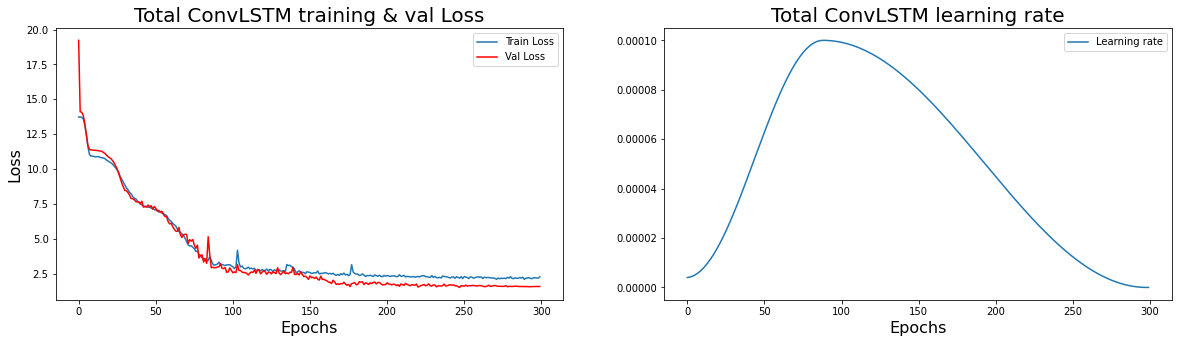

In [107]:
plt.figure(figsize = (20, 5))

plt.subplot(1, 2, 1)
plt.plot(total_convlstm_model.train_record, label="Train Loss") 
plt.plot(total_convlstm_model.val_record, 'r', label="Val Loss") 
plt.title('Total ConvLSTM training & val Loss', fontsize=20) 
plt.xlabel('Epochs',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(total_convlstm_model.lr_record, label="Learning rate")  
plt.title('Total ConvLSTM learning rate', fontsize=20) 
plt.xlabel('Epochs',fontsize=16)
plt.legend()
plt.show()

In [109]:
total_convlstm_test_result = predict(total_convlstm_model, total_convlstm_trainer, answer_sample, test_dataloader)

Best epoch : 247, Best score : 1.5035598754882813


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 95it [00:00, ?it/s]

# Ensemble

In [ ]:
class EnsembleModel():
    def __init__(self, models:List, trainers:List, train_dataloaders:List, val_dataloaders:List):
        self.models = models
        self.trainers = trainers
        self.train_dataloaders = train_dataloaders
        self.val_dataloaders = val_dataloaders
        self.model_count = len(models)

    def train(self):
        for model, trainer, train_dataloader, val_dataloader in zip(self.models, self.trainers, self.train_dataloaders, self.val_dataloaders):
            print(model.name)
            trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    def predict(self, test_dataloader:DataLoader):
        results = []
        for model, trainer in zip(self.models, self.trainers):
            print(f"Best epoch : {model.best_epoch}, Best score : {model.best_score}")
            model.load_state_dict(model.best_model)

            predictions = trainer.predict(model, dataloaders = test_dataloader)

            results.append(np.concatenate([pred.detach().numpy() for pred in predictions]))

        ensemble_result = sum(results)/self.model_count

        return ensemble_result

    def validate(self):
        loss = self.models[0].custom_loss
        val_loss = 0        

        for model, val_dataloader in zip(self.models, self.val_dataloaders):
            print(f"Best epoch : {model.best_epoch}, Best score : {model.best_score}")
            model.load_state_dict(model.best_model) 
            model.eval()          

        for x, y in val_dataloader:
            with torch.no_grad():
                y_hat = sum(model(x) for model in self.models)/self.model_count
                val_loss += loss(y_hat, y)

        for model in self.models:
            model.train()
            
        return val_loss / len(val_dataloader)                

In [ ]:
ensemble_logger = pl.loggers.TensorBoardLogger("Ensemble")

In [ ]:
def get_dataset(seed:int, ratio:float, dataset):
    pl.seed_everything(seed)
    dataset_length = len(dataset)

    train_len = int(dataset_length * ratio)
    val_len = dataset_length - train_len

    train_dataset, val_dataset = random_split(dataset, [train_len, val_len])

    return train_dataset, val_dataset


train_dataloaders = []
val_dataloaders = []

for i in range(ensemble_size):
    train_dataset, val_dataset = get_dataset(2022 + i, train_test_split_ratio, culturedataset)

    train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
    val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
    
    train_dataloaders.append(train_dataloader)
    val_dataloaders.append(val_dataloader)

INFO:pytorch_lightning.utilities.seed:Global seed set to 2022
INFO:pytorch_lightning.utilities.seed:Global seed set to 2023
INFO:pytorch_lightning.utilities.seed:Global seed set to 2024
INFO:pytorch_lightning.utilities.seed:Global seed set to 2025
INFO:pytorch_lightning.utilities.seed:Global seed set to 2026


In [ ]:
ensemble_model = EnsembleModel([ConvLSTMSequenceModel(input_size, hidden_size, num_layers, learning_rate, dropout, len(train_dataloaders[0]), model_id = i) for i in range(ensemble_size)], 
                               [pl.Trainer(max_epochs = epochs, accelerator='gpu', devices=1, logger = ensemble_logger) for _ in range(ensemble_size)],
                               train_dataloaders, 
                               val_dataloaders)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utili

In [ ]:
index = 0
ensemble_model.trainers[index].train(ensemble_model.models[index], 
                                 train_dataloader = ensemble_model.train_dataloaders[index], 
                                 val_dataloader = ensemble_model.val_dataloaders[index])

In [ ]:
index = 1
ensemble_model.trainers[index].train(ensemble_model.models[index], 
                                 train_dataloader = ensemble_model.train_dataloaders[index], 
                                 val_dataloader = ensemble_model.val_dataloaders[index])

In [ ]:
index = 2
ensemble_model.trainers[index].train(ensemble_model.models[index], 
                                 train_dataloader = ensemble_model.train_dataloaders[index], 
                                 val_dataloader = ensemble_model.val_dataloaders[index])

In [ ]:
index = 3
ensemble_model.trainers[index].train(ensemble_model.models[index], 
                                 train_dataloader = ensemble_model.train_dataloaders[index], 
                                 val_dataloader = ensemble_model.val_dataloaders[index])

In [ ]:
index = 4
ensemble_model.trainers[index].train(ensemble_model.models[index], 
                                 train_dataloader = ensemble_model.train_dataloaders[index], 
                                 val_dataloader = ensemble_model.val_dataloaders[index])

In [ ]:
ensemble_model.train()

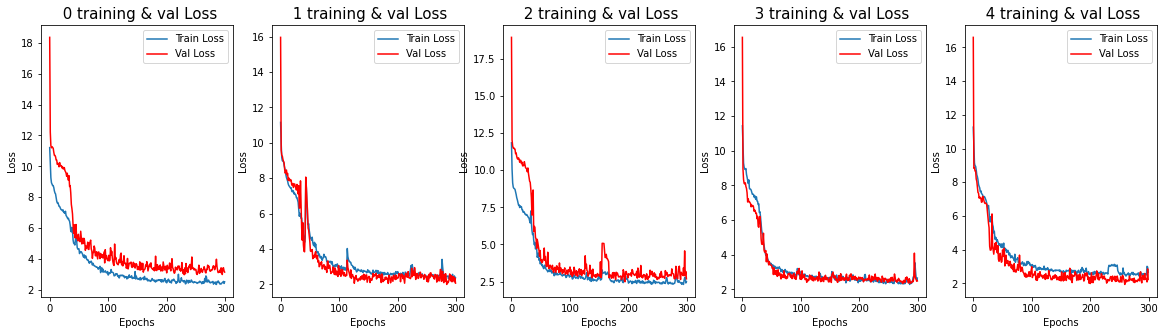

In [ ]:
plt.figure(figsize= (20, 5))

def plot(index):
    plt.subplot(1, ensemble_size, index+1)
    plt.plot(ensemble_model.models[index].train_record, label="Train Loss") 
    plt.plot(ensemble_model.models[index].val_record, 'r', label="Val Loss") 
    plt.title(f' {index} training & val Loss', fontsize=15) 
    plt.xlabel('Epochs',fontsize=10)
    plt.ylabel('Loss',fontsize=10)
    plt.legend()

for i in range(5):
    plot(i)

plt.show()

In [ ]:
ensemble_model.validate()

Best epoch : 230, Best score : 2.9720611572265625
Best epoch : 284, Best score : 1.9950733184814453
Best epoch : 194, Best score : 2.4852108001708983
Best epoch : 274, Best score : 2.3359840393066404
Best epoch : 259, Best score : 1.9400135040283204


tensor(1.4714)

In [ ]:
total_ensemble_model = EnsembleModel([ConvLSTMSequenceModel(input_size, hidden_size, num_layers, learning_rate, dropout, len(total_dataloader), total_dataloader, val_datalaoder, model_id = i) for i in range(ensemble_size)], 
                               [pl.Trainer(max_epochs = epochs, accelerator='gpu', devices=1, logger = ensemble_logger) for _ in range(ensemble_size)],
                               [total_dataloader for _ in range(ensemble_size)], 
                               val_dataloaders)

# Tensorboard

# Predict

In [ ]:
def ensemble_predict(ensemble_model, df, dataloader)->pd.DataFrame:
    ensemble_prediction = ensemble_model.predict(dataloader)
    df[["생장길이", "줄기직경", "개화군"]] = ensemble_prediction

    return df

ensemble_test_result = ensemble_predict(ensemble_model, answer_sample, test_dataloader)

Best epoch : 230, Best score : 2.9720611572265625


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

Best epoch : 284, Best score : 1.9950733184814453


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

Best epoch : 194, Best score : 2.4852108001708983


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

Best epoch : 274, Best score : 2.3359840393066404


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

Best epoch : 259, Best score : 1.9400135040283204


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 91it [00:00, ?it/s]

In [ ]:
ensemble_test_result

Sample_no       조사일    주차        생장길이       줄기직경        개화군
0            9  20220413  32주차  149.364960   6.911427  16.913898
1           12  20170312  30주차  218.489777   9.576738   6.349576
2           19  20170319  31주차  160.076996  10.590499   7.203462
3           23  20170326  32주차  218.247971   8.949499   7.741899
4           27  20170430  37주차  256.624207   7.603536   5.894850
..         ...       ...   ...         ...        ...        ...
501       2015  20160508  14주차  114.509666   7.100458   6.624033
502       2016  20160529  17주차   75.208481   5.178131   6.135268
503       2024  20160828   7주차  127.524841   8.650928   2.699400
504       2025  20160828   7주차  127.524841   8.650928   2.699400
505       2026  20160828   7주차  127.524841   8.650928   2.699400

[506 rows x 6 columns]

In [110]:
ctime = str(datetime.datetime.now())

# torch.save(convlstm_model, f"/content/drive/MyDrive/Colab Notebooks/예선데이터/models/convlstm_{ctime}.pt")
# torch.save(ensemble_model, f"/content/drive/MyDrive/Colab Notebooks/예선데이터/models/ensemble_{ctime}.pt")
torch.save(total_convlstm_model, f"/content/drive/MyDrive/Colab Notebooks/예선데이터/models/total_convlstm_{ctime}.pt")

# convlstm_test_result.to_csv(f"/content/drive/MyDrive/Colab Notebooks/예선데이터/predictions/convlstm_{ctime}.csv", index = False, encoding='utf-8')
# ensemble_test_result.to_csv(f"/content/drive/MyDrive/Colab Notebooks/예선데이터/predictions/ensemble_{ctime}.csv", index = False, encoding='utf-8')
total_convlstm_test_result.to_csv(f"/content/drive/MyDrive/Colab Notebooks/예선데이터/predictions/total_convlstm_{ctime}.csv", index = False, encoding='utf-8')

In [ ]:
hyperparameters = globals()

with open(f"/content/drive/MyDrive/Colab Notebooks/예선데이터/models/hyperparameters_{ctime}.json", "w") as fw:
    json.dump(hyperparameters, fw)

In [ ]:
#  del convlstm_model
# del total_convlstm_model
# del train_dataloader
# del val_dataloader
del ensemble_model